# Imports

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import ndcg_score, dcg_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Чтение данных

In [2]:
movies_df = pd.read_csv(r"C:\Users\sahab\Desktop\vk-ml-t\movies.csv")
ratings = pd.read_csv(r"C:\Users\sahab\Desktop\vk-ml-t\ratings.csv")

# EDA

In [3]:
print(ratings.shape)
ratings.head(5)

(27753444, 4)


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [4]:
print(movies_df.shape)
movies_df.head(5)

(58098, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<AxesSubplot:>

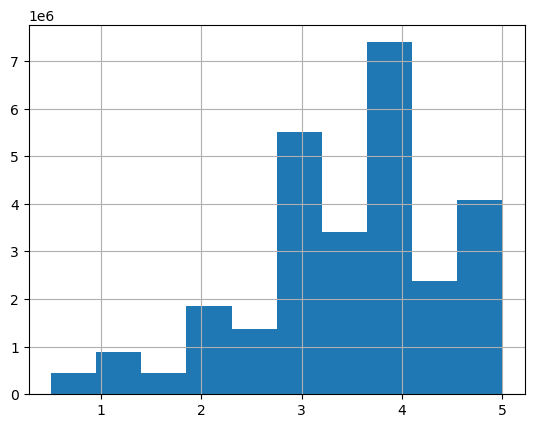

In [5]:
# Распределение оценок
ratings.rating.hist()

20 Фильмов с наибольшим числом оценок

In [6]:
pd.merge(ratings, movies_df, on="movieId", how="inner")\
.groupby("title").agg({'rating': 'count'})\
.sort_values("rating", ascending=False).head(20)

,rating
title,
"Shawshank Redemption, The (1994)",97999
Forrest Gump (1994),97040
Pulp Fiction (1994),92406
"Silence of the Lambs, The (1991)",87899
"Matrix, The (1999)",84545
Star Wars: Episode IV - A New Hope (1977),81815
Jurassic Park (1993),76451
Schindler's List (1993),71516
Braveheart (1995),68803


20 фильмов с самыми высоки показателями оценок и средней оценки

In [7]:
pd.merge(ratings, movies_df, on="movieId", how="inner")\
.groupby("title").agg({'rating': ['count', 'mean']})\
.sort_values([("rating", "count"), ("rating", "count")], ascending=False).head(20)

rating          
                                                    count      mean
title                                                              
Shawshank Redemption, The (1994)                    97999  4.424188
Forrest Gump (1994)                                 97040  4.056585
Pulp Fiction (1994)                                 92406  4.173971
Silence of the Lambs, The (1991)                    87899  4.151412
Matrix, The (1999)                                  84545  4.149695
Star Wars: Episode IV - A New Hope (1977)           81815  4.120455
Jurassic Park (1993)                                76451  3.665034
Schindler's List (1993)                             71516  4.257502
Braveheart (1995)                                   68803  4.008481
Toy Story (1995)                                    68469  3.886649
Star Wars: Episode VI - Return of the Jedi (1983)   66023  3.986043
Star Wars: Episode V - The Empire Strikes Back ...  65822  4.133481
Fight Club (1999)                                   65678  4.230663
Terminator 2: Judgment Day (1991)                   64258  3.941501
Raiders of the Lost Ark (Indiana Jones and the ...  63505  4.120455
Usual Suspects, The (1995)                          62180  4.291959
Lord of the Rings: The Fellowship of the Ring, ...  61883  4.097943
Godfather, The (1972)                               60904  4.332893
American Beauty (1999)                              60820  4.121506
Independence Day (a.k.a. ID4) (1996)                58949  3.397165

In [8]:
ratings.userId.nunique(), ratings.movieId.nunique()

(283228, 53889)

In [9]:
ratings.userId.min(), ratings.userId.max()

(1, 283228)

In [10]:
ratings.movieId.min(), ratings.movieId.max()

(1, 193886)

# Подготовка данных

Соединение датафреймов рейтингов и фильмов

In [11]:
train = pd.merge(ratings, movies_df, on="movieId", how="inner")

In [12]:
train.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,307,3.5,1256677221,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1,6,307,4.0,832059248,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
2,56,307,4.0,1383625728,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,71,307,5.0,1257795414,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
4,84,307,3.0,999055519,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama


Создание train, test

In [13]:
def l_o_o(train):
    '''
    Функция для семплирования данных. 
    Чтобы в обучаеющей выборке были все пользователи,
    выдаем оценкам каждого пользователя рейтинги и отправляем последнюю оценку в трейн.
    Так же функция делает таргет бинарным,
    исходя из того что нам нужно предсказать захочет ли пользователь посмотреть фильм,
    а не рейтинг, который он ему поставит
    '''
    #Скейлим рейтинг от 0 до 1, потому что у каждый пользователь ставить оценки по разному(кто-то только 1 и 5, кто-то всему 3 и тд.)
    scaler = MinMaxScaler()
    target = scaler.fit_transform(train.rating.values.reshape(-1, 1))
    train["target"] = target
    
    #Делаем таргет бинарным     
    train["target"] = train["target"].apply(lambda x: 1 if x > 0.6 else 0)
    users_count_g = train.groupby("userId").count()[["movieId"]]
    users_ones = users_count_g[users_count_g["movieId"] == 1].index.to_numpy()
    only_one_example = train[(train["userId"].isin(users_ones))][["userId", "movieId", "target"]]
    
    #Отбираем пользователей с одним интерактом, чтобы добавить в трейн     
    train_without_ones = train[~(train["userId"].isin(users_ones))]
    
    #Отправляем в трейн все взаимодействия кроме последнего
    train_without_ones['rank_latest'] = train_without_ones\
    .groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
    train_ratings = train_without_ones[train_without_ones['rank_latest'] != 1]
    test_ratings = train_without_ones[train_without_ones['rank_latest'] == 1]
    train_ratings = train_ratings[["userId", "movieId", "target"]]
    test_ratings = test_ratings[["userId", "movieId", "target"]]
    
    #Соединяем трейн и фрейм с пользователями у которых по одной интеракции 
    train_ratings = pd.concat([train_ratings, only_one_example], ignore_index=True)
    
    return train_ratings, test_ratings

train_ratings, test_ratings = l_o_o(train)

Разбиение на train, test

In [14]:
X_train = train_ratings[["userId", "movieId"]]
y_train = train_ratings[["target"]]
X_valid = test_ratings[["userId", "movieId"]]
y_valid = test_ratings[["target"]]

Создание torch Dataloader для обучения

In [15]:
train_tensor = TensorDataset(
    torch.from_numpy(X_train.values).to(torch.int64),
    torch.from_numpy(y_train.values).float())
test_tensor = TensorDataset(
    torch.from_numpy(X_valid.values).to(torch.int64),
    torch.from_numpy(y_valid.values).float())

train_loader = DataLoader(train_tensor, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=1024, shuffle=True)

# Модель

![](https://miro.medium.com/v2/resize:fit:1400/1*aP-Mx266ExwoWZPSdHtYpA.png)

In [16]:
# Создаем нейросетевую модель архитектуры neural collaborative filtering
# У сети два входа - пользователь и фильм, на этих входах обучаются эмбеддинги, после чего эмбеддинги конкатенируются и передаются в полносвяхную сеть
# Выход сети - вероятность того, что пользователь захочет 
class NCF(nn.Module):
    def __init__(self,
                 n_users, # Число пользователей для обучения векторных представлений
                 n_movies, # Число фильмов для обучения векторных представлений
                 n_dim, # Размерность эмбеддингов
                 n_hid_layers=2, # Количество слоев в полносвязной сети
                 dropout=0.5,
                 target="bin",
                ): # Количество выключаемых нейронов в полносвязной сети
        super().__init__()
        def generate_dense(inp_s, out_s, n_hid_layers):
#           Функция для создания полносвязной сети
            layers = []
            size_cnt = inp_s
            for i in range(n_hid_layers):
                layers.append(nn.Linear(size_cnt, size_cnt//2))
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
                size_cnt = size_cnt//2
            layers.append(nn.Dropout(dropout))
            layers.append(nn.Linear(size_cnt, out_s))
            net = nn.Sequential(*layers)
            return net
        
#       эмбеддинги пользователей и фильмов
        self.u_emb = nn.Embedding(n_users, n_dim)
        self.m_emb = nn.Embedding(n_movies, n_dim)
#       Полносвязная сеть для обработки сконкатенированных эмбеддингов
        self.dense = generate_dense(n_dim*2, 1, n_hid_layers)
        self.target = target
        
    def forward(self, users, movies):
#       Конкатанирование эмбеддингов и обучение полносвязной сети
        x = torch.cat([self.u_emb(users), self.m_emb(movies)], dim=1)
        if self.target == "bin":
            x = nn.Sigmoid()(self.dense(x))
        else:
            x = self.dense(x)
        return x
    

# Обучение

цикл обучения

In [18]:
n_users = train.userId.max()+1
n_movies = train.movieId.max()+1
emb_dim = 256
net = NCF(n_users, n_movies, emb_dim, n_hid_layers=1)

# Объявление параметров обучения
lr = 1e-3
n_epochs = 100
patience = 2
best_loss = np.inf
best_loss_cnt = 0
best_epoch = 0
history = []
net.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

# Цикл обучения
for epoch in tqdm(range(n_epochs)):
    running_loss_train = 0.0
    running_loss_test = 0.0
#     обучение
    for (X, y) in train_loader:
        X_d = X.to(device)
        y_d = y.to(device)
        optimizer.zero_grad()
        outputs = net(X_d[:, 0], X_d[:, 1])
        loss = criterion(outputs, y_d)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
    train_epoch_loss = running_loss_train/len(X_train)
    
#     валидация модели
    with torch.no_grad():
        for (X, y) in test_loader:
            X_d = X.to(device)
            y_d = y.to(device)
            outputs = net(X_d[:,0], X_d[:, 1])
            loss = criterion(outputs, y_d)
            running_loss_test += loss.item()
        test_epoch_loss = running_loss_test/len(X_valid)
    
#     Сохраняем лучшую модель за пройденые эпохи
    if test_epoch_loss < best_loss:
        best_loss = test_epoch_loss
        torch.save(net.state_dict(), 'rnet_best.pt')
        best_loss_cnt = 0
        best_epoch = epoch
    else:
        best_loss_cnt += 1
        
#     Сохраняем лосс на эпохе
    history.append((train_epoch_loss, test_epoch_loss))
    print(
        f"epoch №{epoch};",
        f"train loss:{train_epoch_loss};",
        f"test loss: {test_epoch_loss};\n",
        f"best test_loss: {best_loss} on epoch {best_epoch}"
    )
    
#     Ранняя остановка модели
    if best_loss_cnt >= patience:
        print(f"early stopping\n train ended with best loss {best_loss} on epoch {best_epoch}")
        break
        

  0%|          | 0/100 [07:41<?, ?it/s]


KeyboardInterrupt: 

График эпох обучения

In [ ]:
pd.DataFrame(history, columns=('train', 'test')).plot()
plt.axvline(x = best_epoch, color = 'r')

Загружаем веса модели

In [17]:
n_users = train.userId.max()+1
n_movies = train.movieId.max()+1
emb_dim = 256

loaded_model = NCF(n_users, n_movies, emb_dim, n_hid_layers=1)
loaded_model.load_state_dict(
    torch.load(r"C:\Users\sahab\Downloads\rnet_best (9).pt"
              ))
loaded_model.eval()

NCF(
  (u_emb): Embedding(283229, 256)
  (m_emb): Embedding(193887, 256)
  (dense): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

Пример рекомендаций для одного пользователя

In [18]:
preds = []

with torch.no_grad():
    for i in X_valid.movieId.unique():
            pred = loaded_model(
                torch.tensor([111486]), torch.tensor([i])
            ).detach().numpy()[0][0]
            preds.append((i, pred))
answer = pd.merge(pd.DataFrame(preds),
                  movies_df, left_on=0,
                  right_on="movieId", how="inner")
answer = answer.sort_values(1, ascending=False).head(100)\
.sample(20)[["movieId", "title"]]
answer

,movieId,title
11536,87960,Between the Folds (2008)
6813,73323,"Girl Who Kicked the Hornet's Nest, The (Luftsl..."
11704,185927,Wild Wild Country (2018)
6500,170705,Band of Brothers (2001)
9034,92954,Prayers for Bobby (2009)
1057,160718,Piper (2016)
8879,129779,Ghost in the Shell Arise - Border 1: Ghost Pai...
5612,170777,There Once Was a Dog (1982)
9768,187717,Won't You Be My Neighbor? (2018)
5969,147286,The Adventures of Sherlock Holmes and Doctor W...


In [19]:
train[train["userId"] == 111486]\
.sort_values("rating", ascending=False)\
.head(100).sample(20)[["title"]]

,title
11852369,Get Shorty (1995)
21679950,Pirates of Silicon Valley (1999)
8121028,Spaceballs (1987)
9356569,Jay and Silent Bob Strike Back (2001)
9763187,Spider-Man (2002)
6857041,Ronin (1998)
7126013,Office Space (1999)
4300719,Die Hard (1988)
5560215,Austin Powers: International Man of Mystery (1...
9145095,Scarface (1983)


# Валидация

Для валидации я использую HR@K, MAP@K, F1@K, p@K, r@k, nDCG@K

In [20]:
def get_predict(user_id, movie_id):
    '''
    Функция, выдающая предикт для одного фильма и одного пользователя
    '''
    with torch.no_grad():
        pred = loaded_model(
            torch.tensor([user_id]), torch.tensor([movie_id])
        ).detach().numpy()[0][0]
    return pred

def get_n_recommendations(user_id, movie_ids_collect,
                          movies_df, n):
    '''
    Функция, выдающая top-n рекомендаций 
    '''
    preds = []
    for i in movie_ids_collect:
        pred = get_predict(user_id, i)
        preds.append((i, pred))
    answer = pd.merge(
        pd.DataFrame(preds),
        movies_df, left_on=0,
        right_on="movieId", how="inner"
    )
    
    answer = answer.sort_values(1, ascending=False).head(n)
    return answer

In [56]:
test_ids = test_ratings.sample(10000).userId.unique()

HR@10 для 10000 пользователей

Метрика Hit Ratio @ k - это метрика,
используемая в рекомендательных системах для оценки качества рекомендаций.
Она показывает, как часто рекомендуемые элементы появляются в топ-k рекомендациях.

In [51]:
data = test_ratings[test_ratings["userId"].isin(test_ids)]
test_user_item_set = list(set(zip(data['userId'], data['movieId'])))

user_interacted_items = train.groupby('userId')['movieId'].apply(list).to_dict()

hits = []

for (u, i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(train.movieId.unique()) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    with torch.no_grad():
        predicted_labels = np.squeeze(
            loaded_model(torch.tensor([u]*100), 
            torch.tensor(test_items)).detach().numpy()
        )
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]    
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [31:40<00:00,  5.26it/s]

The Hit Ratio @ 10 is 0.38


MAP@10 для 10000 пользователей

Mean Average Precision (MAP) @ k - это метрика, которая используется для оценки качества рекомендательных систем. Она измеряет, насколько хорошо система ранжирует рекомендации для пользователя.
MAP @ k означает, что мы рассматриваем только первые k рекомендаций, которые были предложены пользователю. 

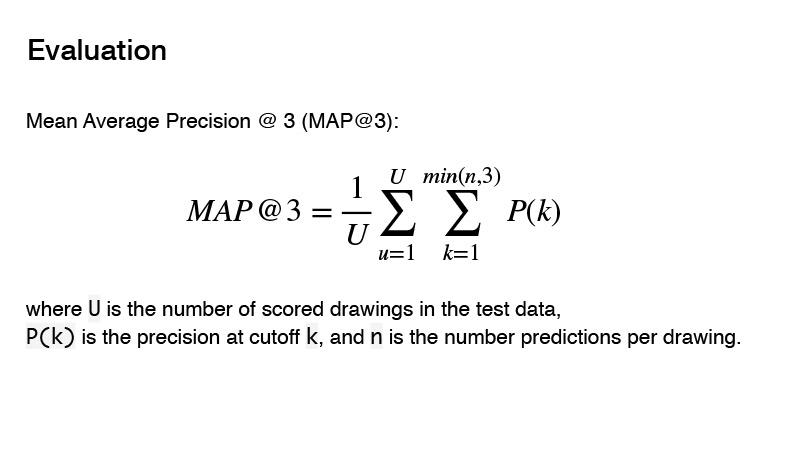

In [52]:
def apk(actual, predicted, k=10):
    '''
    AP@K
    '''
    if len(predicted)>k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    '''
    MAP@K
    '''
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


user_interacted_items = train.groupby('userId')['movieId'].apply(list).to_dict()
actual_list = []
predicted_list = []
for u in tqdm(test_ids):
    actual = user_interacted_items[u]
    actual_list.append(actual)
    not_interacted_items = set(train.movieId.unique()) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 9*len(actual)))
    test_items = selected_not_interacted + actual
    with torch.no_grad():
        predicted_labels = np.squeeze(
            loaded_model(torch.tensor([u]*10*len(actual)), 
            torch.tensor(test_items)).detach().numpy()
        )
        top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    predicted_list.append(top10_items)
actual_list = list(map(list, actual_list))

print("MAP @ 10 is {:.2f}".format(mapk(actual_list, predicted_list)))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [31:21<00:00,  5.31it/s]


MAP @ 10 is 0.22


Precision@K, recall@K, F1@K для 10000 пользователей

Precision@K - метрика, которая показывает долю правильно предсказанных объектов среди первых K объектов в выдаче модели. 

Recall@K - метрика, которая показывает долю правильно предсказанных объектов, которые были найдены в первых K объектах в выдаче модели.

F1@K - метрика, которая является гармоническим средним между precision@K и recall@K. Она показывает баланс между precision и recall для первых K объектов в выдаче модели. 
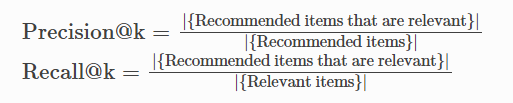
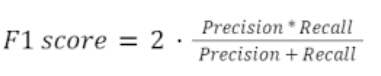

In [53]:
def precision_at_k(actual, predicted, k=10):
    '''
    P@K
    precision = hits / k
    '''
#     print(actual, predicted)
    if len(predicted) > k:
        predicted = predicted[:k]
    hits = 0
    for i in predicted:
        if i in actual:
            hits += 1
            
    precision = hits / k
    return precision

def recall_at_k(actual, predicted, k=10):
    '''
    R@K
    recall = hits / num_actual
    '''
    if len(predicted) > k:
        predicted = predicted[:k]
    num_actual = len(actual)
    hits = 0
    for item in predicted:
        if item in actual:
            hits += 1
    recall = 0
    if num_actual > 0:
        recall = hits / num_actual
    return recall

user_interacted_items = train.groupby('userId')['movieId'].apply(list).to_dict()

precision_at_k_list = []
recall_at_k_list = []

for u in tqdm(test_ids):
    actual = user_interacted_items[u]
    not_interacted_items = set(train.movieId.unique()) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 9*len(actual)))
    test_items = selected_not_interacted + actual
    with torch.no_grad():
        predicted_labels = np.squeeze(
            loaded_model(torch.tensor([u]*10*len(actual)), 
            torch.tensor(test_items)).detach().numpy()
        )
        top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    precision_at_k_list.append(precision_at_k(actual, top10_items))
    recall_at_k_list.append(recall_at_k(actual, top10_items))

p_a_10 = np.array(precision_at_k_list).mean()
rec_a_10 = np.array(recall_at_k_list).mean()

print(f"mean precision at 10 is {p_a_10}")
print(f"mean recall at 10 is {rec_a_10}")
print(f"mean f1 at 10 is {2*(p_a_10 * rec_a_10)/(p_a_10 + rec_a_10)}")

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [31:04<00:00,  5.36it/s]

mean precision at 10 is 0.339
mean recall at 10 is 0.1599234551580397
mean f1 at 10 is 0.21732412352272573


# Сравнение с системой, которая дает всем самое популярное в качестве рекомендаций

In [47]:
most_popular_10 = train.groupby("movieId")\
.agg({'rating': 'count'})\
.sort_values("rating", ascending=False)\
.head(10).reset_index()\
.movieId.values.tolist()

MAP@10 для 10000 пользователей

In [57]:
actual_list = []
predicted_list = []

user_interacted_items = train.groupby('userId')['movieId'].apply(list).to_dict()

for u in tqdm(test_ids):
    actual = user_interacted_items[u]
    actual_list.append(actual)
    predicted_list.append(most_popular_10)
    
actual_list = list(map(list, actual_list))

print("MAP @ 10 is {:.2f}".format(mapk(actual_list, predicted_list)))

100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1249941.59it/s]

MAP @ 10 is 0.23


HR@10 для 10000 пользователей

In [58]:
data = test_ratings[test_ratings["userId"].isin(test_ids)]
test_user_item_set = list(set(zip(data['userId'], data['movieId'])))

hits = []

for (u, i) in tqdm(test_user_item_set):
    if i in most_popular_10:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1999763.52it/s]

The Hit Ratio @ 10 is 0.04


Precision@K, recall@K, F1@K для 10000 пользователей

In [59]:
user_interacted_items = train.groupby('userId')['movieId'].apply(list).to_dict()

precision_at_k_list = []
recall_at_k_list = []

for u in tqdm(test_ids):
    precision_at_k_list.append(precision_at_k(actual, most_popular_10))
    recall_at_k_list.append(recall_at_k(actual, most_popular_10))

p_a_10 = np.array(precision_at_k_list).mean()
rec_a_10 = np.array(recall_at_k_list).mean()

print(f"mean precision at 10 is {p_a_10}")
print(f"mean recall at 10 is {rec_a_10}")
print(f"mean f1 at 10 is {2*(p_a_10 * rec_a_10)/(p_a_10 + rec_a_10)}")

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 97029.50it/s]

mean precision at 10 is 0.20000000000000004
mean recall at 10 is 0.02531645569620254
mean f1 at 10 is 0.04494382022471912


Таблица сравнения метрик модели и константных рекомендаций в виде самых популярных фильмов

| Model    | MAP@10 | HR@10 | P@10 | R@10 | F1@K |
|----------|--------|-------|------|------|------|
| NCF      |    0.22|0.380   |0.339 | 0.159|0.217 |
| Constant |    0.23|0.040   |0.200 |0.025 |0.044 |